# Module 10: Markov Chain Monte Carlo (MCMC) - Part 2

### Introduction to PyMC3

In this section we demonstrate how the Python PyMC3 library can be applied for Bayesian inference analysis and for the estimation of model parameters using the Monte Carlo Markov Chain technique.

References:
 - https://github.com/markdregan/Bayesian-Modelling-in-Python
 - https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/
 - https://docs.pymc.io

### PyMC3 installation

- via pypi:
`pip install pymc3`
- via conda-forge:
`conda install -c conda-forge pymc3`
- the latest (may be unstable) version can be downloaded from github.com:   
`pip install git+https://github.com/pymc-devs/pymc3`

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('./module10/hangout_chat_data.csv')

### Bayesian method of estimating model parameters

In this example, a Bayesian approach is used to estimate model parameters. This dataset is taken from Mark Regan's chat dataset; it shows the time taken to respond to messages.  

In the Bayesian approach the data is considered to be generated by a random process.   

Because the response time is count data, it is natural to model it as a Poisson distribution. The goal here is to estimate the parameter of the distribution $\lambda$ and represent the uncertainty in this parameter.

In other words we need to find the posterior distribution for the parameter $\lambda$ using the Bayesian formula:
 
$$\overbrace{p(\lambda \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \lambda)}^{\text{likelihood}} \cdot \overbrace{p(\lambda)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

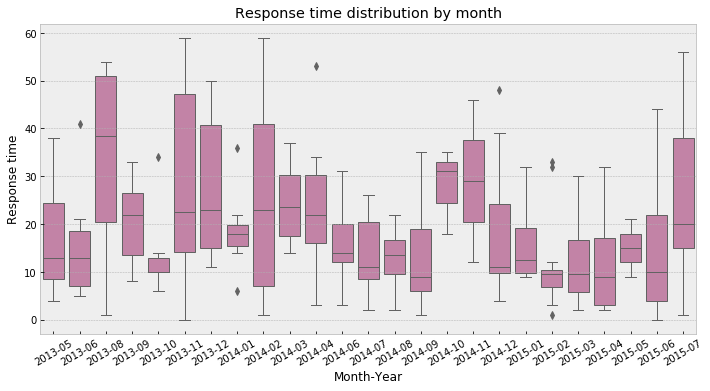

In [2]:
# Let's plot the observed data distribution
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)

order = np.sort(messages['year_month'].unique())
sns.boxplot(x=messages['year_month'], y=messages['time_delay_seconds'], order=order, orient="v", color=colors[5], linewidth=1, ax=ax)
_ = ax.set_title('Response time distribution by month')
_ = ax.set_xlabel('Month-Year')
_ = ax.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

# ax = fig.add_subplot(212)
# plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled', color=colors[0])
# _ = ax.set_title('Response time distribution')
# _ = ax.set_xlabel('Response time (seconds)')
# _ = ax.set_ylabel('Number of messages')

plt.tight_layout()

# fig = plt.figure(figsize=(11,3))
# _ = plt.title('Frequency of messages by response time')
# _ = plt.xlabel('Response time (seconds)')
# _ = plt.ylabel('Number of messages')
# _ = plt.hist(messages['time_delay_seconds'].values, 
#              range=[0, 60], bins=60, histtype='stepfilled')

In [3]:
messages.describe()

,message_length,num_participants,time_delay_seconds,time_delay_mins,day_of_week,is_weekend
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,31.500000,2.139098,18.041353,0.992481,2.357143,0.071429
std,28.502003,0.498501,13.430821,0.086547,1.530904,0.258025
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,8.000000,1.000000,1.000000,0.000000
50%,23.000000,2.000000,14.000000,1.000000,2.000000,0.000000
75%,43.750000,2.000000,25.000000,1.000000,3.000000,0.000000
max,145.000000,4.000000,59.000000,1.000000,6.000000,1.000000


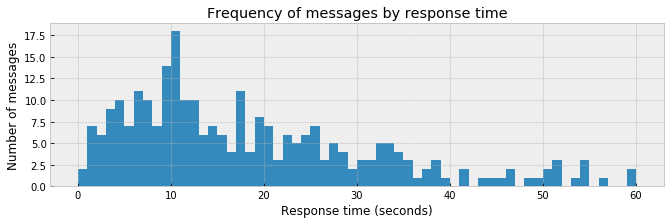

In [4]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

To run this analysis, we need to choose the likelihood and the prior distribution.
- Observed data: counts of response time for each conversation;
- Likelihood: These data were generated by a random process which can be represented as a Poisson distribution;
- For the prior, the distribution of the Poisson distribution $\lambda$ has to be chosen. From the observed data, we know that this parameter is between 0 and 60. We can start to model $\lambda$ as a uniform distribution because we do not have an opinion as to where within this range to expect it.

To derive the posterior distribution, the MCMC sampler draws parameter $\lambda$ values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values. 

$$\overbrace{p(\lambda \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \lambda)}^{likelihood} \cdot \overbrace{p(\lambda)}^{prior}$$

As the MCMC sampler draws values from the parameter priors, it computes the likelihood of these parameters given the data - and the sampling method (for example, Metropolis) will try to guide the sampler towards parameter values of higher probability.

In [5]:
with pm.Model() as model:
    lambda_ = pm.Uniform('lambda', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=lambda_, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step, start=start, progressbar=True)

/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,608.5, ||grad|| = 1,590.5: 100%|██████████| 7/7 [00:00<00:00, 764.69it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda]
Sampling 4 chains: 100%|██████████| 402000/402000 [00:41<00:00, 9785.13draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In the above code, our model is implemented with the uniform distribution for the prior distribution, and the Poisson distribution for the likelihood. 

The PyMC3 method `find_MAP()` was used to find the most likely value of $\lambda$ for the starting point. This is optional, but often speeds up the computation. 

The step specifies what sampling method is used for guidance towards the most likely parameter values.  

And finally, the PyMC3 function `sample()` gathers the samples (100,000 samples in this case) by traversing over the areas of the most likely parameter values. This is the main entry point to the MCMC sampling algorithms. This function takes a defined sampler passed as step, or if step is not passed will try to auto-assign the correct sampler and auto-initialize it.

The PyMC3 library has methods for graphical representation of the collected samples; below, the `traceplot` method is used to show the determined posterior distribution of $\lambda$.

The below plot (left) shows the posterior distribution of values collected for $\lambda$. In this case, we obtained a bell-shaped distribution for the parameter even though the prior is the uniform distribution. The mean is slightly over 18.0 sec and the obtained distribution provides a measure of uncertainty: credible values of $\lambda$ are between 17.0 and 19.0 seconds.

This result shows the difference between the frequentist approach, where the parameter $\lambda$ is estimated as the mean value of 'time_delay_seconds' and is given as a single value. In contrast, from Bayesian analysis, we get the parameter value with a measure of uncertainty. This measure of uncertainty is incredibly valuable, as we will see later. Note that the mean of posterior distribution is very close to the frequentist estimate.

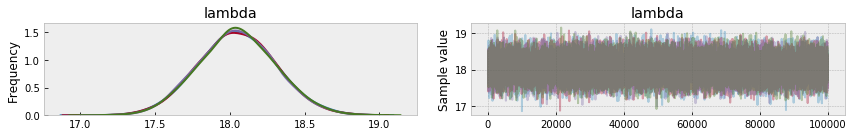

In [6]:
lambda_trace = pm.traceplot(trace, varnames=['lambda'])

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda,18.044703,0.258279,0.001188,17.521937,18.533559,42118.259904,1.000029


### Model convergence

The _trace plots_ show the history of a parameter value across iterations of the chain. It shows the value of parameters explored on each iteration step. If the model reached equilibrium there should not be any trends observed. The trace should look random around some constant value, should be jumping around and look like a "hairy caterpillar". Any trends (periodicity, upward or downward trend) indicate that the chain has not converged to stationary equilibrium state yet and the number of iteration has to be increased. 

Also, it is recommended to inspect sample autocorrelation - the measure of correlation between successive samples in the chain. An autocorrelation plot should taper off to zero relatively quickly, and then oscillate around zero. If your autocorrelation plot does not taper off, the model selection (likelihood) and sampling methods should be revisited. 

The _effective sample size_ (ESS) shows the number of points that bring useful information. The effective sample size is usually given in the summary of MCMC simulation output. The ESS is related to autocorrelation. Since autocorrealtion measures the linear dependence of the current chain value on the past value (lags), it helps to estimate how much information is available. Due to autocorrelation Markov chain sampling 1000 iteration would contain less information about the distribution thag 1000 samples independently drawn from that distribution. Autocorrelation guides how iterations should be thinned out untile autocorrelation is close to 0 

### Burnin samples

In the above code the function `pm.find_MAP()` was used to find a good starting point for sampling. This function finds a maximum a posteriori (MAP) estimation and helps to start sampling in the area of high likelihood. But sometimes the wrong maximum can be detected, and it is recommended to discard the samples collected at the early stage (burnin samples) as they might be biased by the choice of starting point. The initial point of the chain does not affect the posterior distribution. For any starting point we expect the chain to find the bulk of posterior distribution and get the stationary distribution. However, if chain started far from the significant regions it would take longer to find stationary distribution. From trace plot inspection, especially the initial period, it is possible to detect the time chain took to converge. The initial period is called _burn-in period_ and should always be discarded form the posterior distributio. Sometimes, up to 90% of trace is discarded.

The standard practice is to simulate several chains at once. Each starting at diffeent initial value. The diagnostic method (Gelman-Rubin) was developed which calculates variability within chains, comapring that to variability between chains.

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


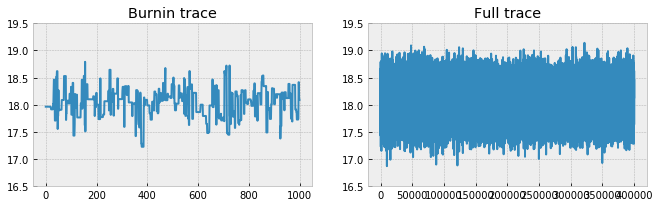

In [8]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('lambda')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('lambda'))

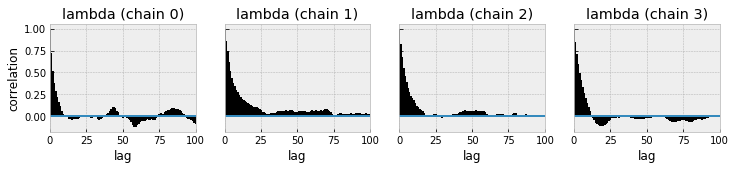

In [9]:
_ = pm.autocorrplot(trace[:2000], varnames=['lambda'])

As a validation check of model performance, we shall generate the distribution of the response time.   
The postrior predictive check is one of the ways to validate a model, this generate the data from the model using parameter drawn from the posterior distribution.   
While `plot_posterior` function plots the posterior distributions of the model parameters, the `sample_posterior_predictive(trace, samples= N , model= ... )` will randomly draw N samples from the trace, which contains the posterior distribution. This will produce N sets of the model parameters; then for each sample of the parameters it will draw (or 'simulate') the data distribution.   
This method will produce N 'simulated' datasets; these might be inspected individually or aggregate them into one distribution, for example by finding average of N distributions.   
Note that the function returns a dictionary {'likelihood': array of N distributions [...], [...], ... [...]}

In [10]:
ppc_hangout = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 2828.90it/s]


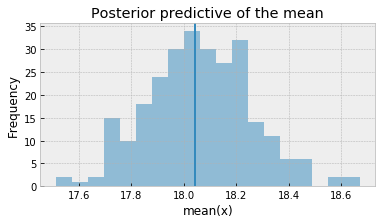

In [11]:
# evaluating distribution of posterior mean parameter vs true sample mean
_, ax = plt.subplots(figsize=(6, 3))
ax.hist(ppc_hangout['likelihood'].mean(axis=0), bins=19,alpha=0.5)
ax.axvline(messages['time_delay_seconds'].values.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

### Logistic regression with parameters estimated from Bayesian inference

In [12]:
import theano.tensor as tt
import numpy as np

In [13]:
challenger_data = np.genfromtxt("./module10/challenger_data.csv", skip_header=1, usecols = [1,2], missing_values ="NA", delimiter=",")

In [14]:
challenger_data = challenger_data[~np.isnan(challenger_data[:,1])]
challenger_data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

Of the previous 24 flights, data were available on failures of the O-rings on 23. Only the data corresponding to the 7 flights on which there was a damage incident were considered important, and these were thought to show no obvious trend.

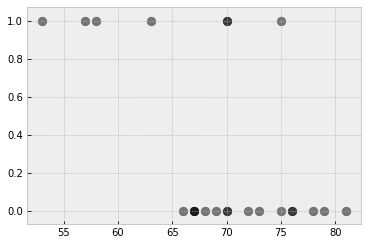

In [15]:
plt.scatter(challenger_data[:,0], challenger_data[:, 1], s=75, color="k", alpha=0.5)

It looks clear that the probability of damage incidents occurring increases as the outside temperature decreases. The best we can do is ask "At temperature t, what is the probability of a damage incident?".

We need a function of temperature, call it p(t), that is bounded between 0 and 1, and gradually changes as we increase temperature.

The logistic function is the most popular choice.

In [16]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [17]:
temperature  = challenger_data[:, 0]
D = challenger_data[:,1]

with pm.Model() as model_logit:
    beta = pm.Normal("beta", mu=0, tau=0.0001, testval = 0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval = 0)
    p = pm.Deterministic("p", 1.0/(1.0 + tt.exp(beta*temperature + alpha)))
    
    observed = pm.Bernoulli("bernoulli_obs", p, observed = D)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace =  pm.sample(200000, start=start, step=step, progressbar=True)
    burned_trace = trace[100000::2]

/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -20.175, ||grad|| = 9.907: 100%|██████████| 27/27 [00:00<00:00, 2069.44it/s]   
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains: 100%|██████████| 802000/802000 [01:40<00:00, 7968.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


To connect probabilities to observed data, we use a Bernoulli random variable with parameter p. It takes value 1 with probability p, and 0 otherwise.

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


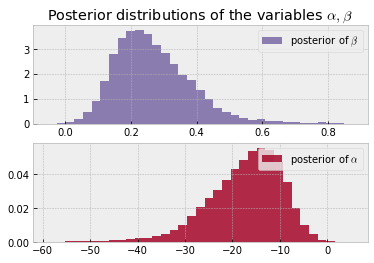

In [18]:
alpha_samples = burned_trace["alpha"][:, None]
beta_samples = burned_trace["beta"][:, None]


plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [19]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

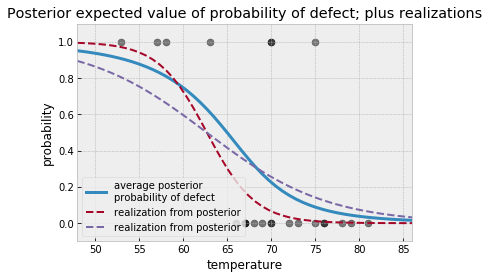

In [20]:
plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

### Bayesian linear regression

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
bike_sharing = pd.read_csv('./module10/bikes_sharing.csv', header=0, sep= ',')

In [23]:
bike_sharing.isnull().values.any()

False

In [24]:
bike_sharing.shape

(10886, 12)

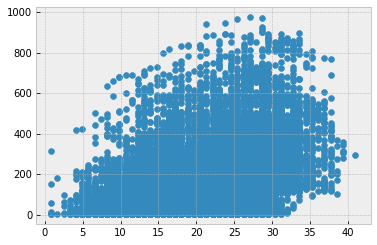

In [25]:
plt.scatter(x=bike_sharing['temp'], y=bike_sharing['count'])

In [26]:
bike_sharing.datetime = bike_sharing.datetime.apply(pd.to_datetime)

bike_sharing['month'] = bike_sharing.datetime.apply(lambda x : x.month)
bike_sharing['hour'] = bike_sharing.datetime.apply(lambda x : x.hour)

In [27]:
# we want to predice bike renting at certain time (15:00 - 15:59)

bike_sharing_15 = bike_sharing.loc[bike_sharing['hour'] == 15]

Text(0, 0.5, 'Count')

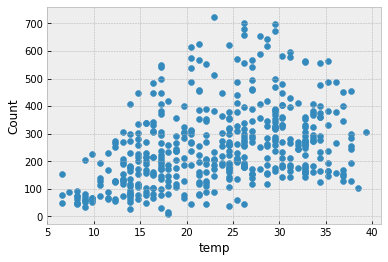

In [28]:
plt.scatter(x=bike_sharing_15['temp'], y=bike_sharing_15['count'])

plt.xlabel("temp")
plt.ylabel('Count')

In [29]:
# Preparation of X and y for simulation

X=bike_sharing_15.loc[:,['humidity', 'atemp']]
y = bike_sharing_15.loc[:, "count"]

In [30]:
lin_reg=LinearRegression()
lin_reg.fit(X.atemp.values.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
print('Intercept:', lin_reg.intercept_)
print('Slope:', lin_reg.coef_)

Intercept: 78.64994444157625
Slope: [6.54614017]


In [32]:
lin_reg.intercept_+lin_reg.coef_[0]*20

209.57274780495794

Implement MCMC to find the posterior distribution of the model parameters. Rather than a single point estimate of the model weights, Bayesian linear regression will give us a posterior distribution for the model weights.

In [33]:
with pm.Model() as linear_model:
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate
    mean = intercept + slope * X.loc[:, 'atemp']
    
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    #Sampler
    step = pm.NUTS()
    
    linear_trace = pm.sample(20000, step=step, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2913.13draws/s]
The acceptance probability does not match the target. It is 0.8852432542850333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854486193828859, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945494215251486, but should be close to 0.8. Try to increase the number of tuning steps.


In [34]:
linear_trace.mean_tree_accept.mean()

0.8814988619015427

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c245579b0>,
      dtype=object)

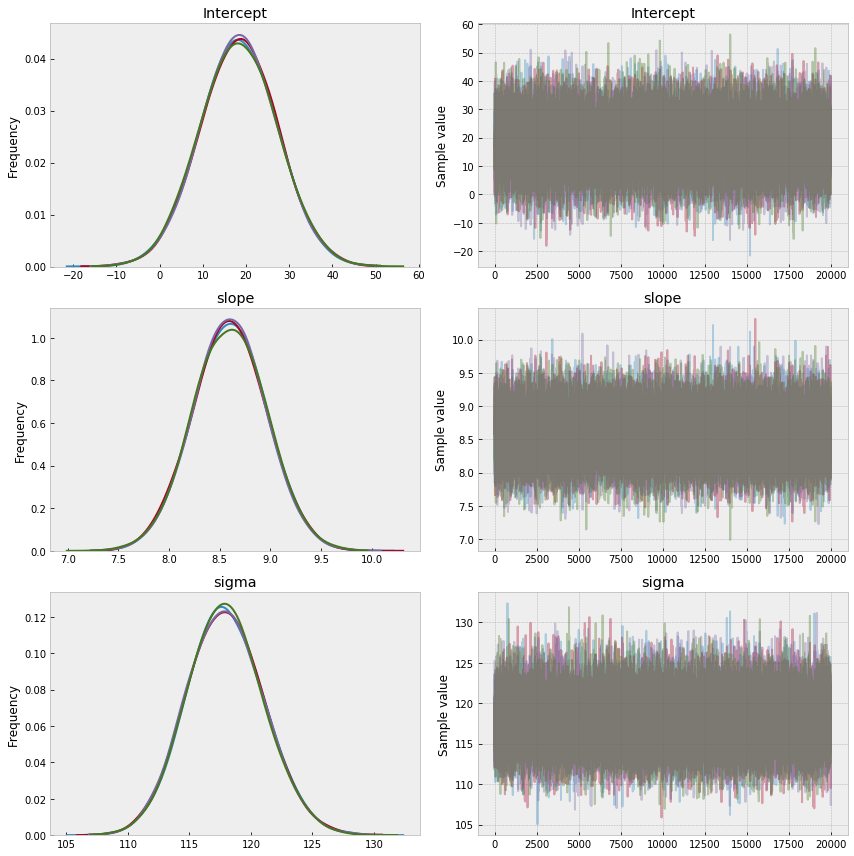

In [35]:
pm.traceplot(linear_trace, figsize=(12,12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c235acba8>,
      dtype=object)

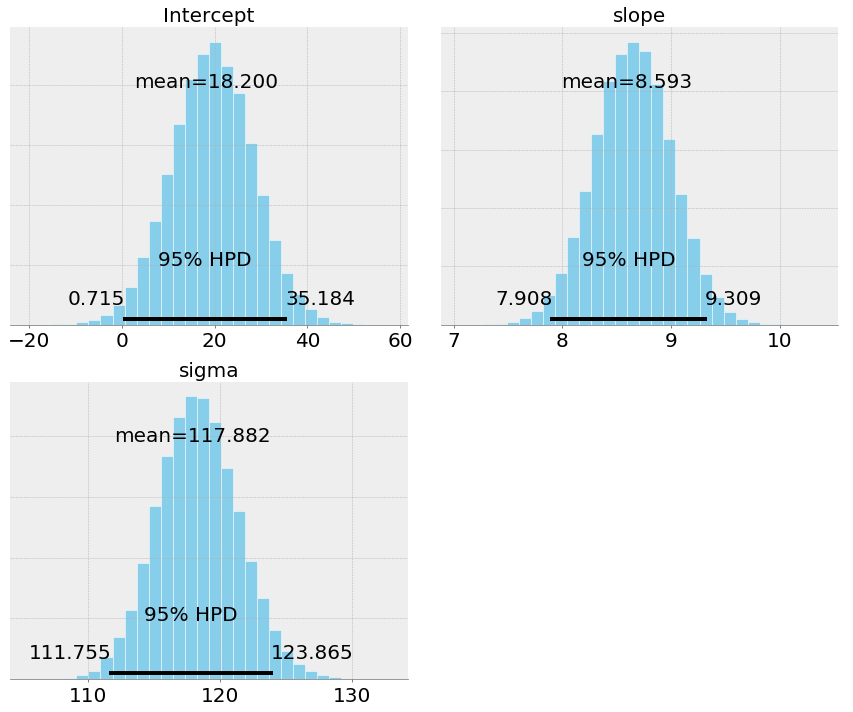

In [36]:
pm.plot_posterior(linear_trace, figsize=(12,10), text_size=20)

### Prediction of response

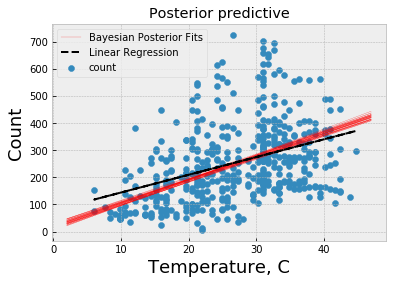

In [37]:
pm.plot_posterior_predictive_glm(linear_trace, eval=np.linspace(2,47, 100), 
                                 color='red', label = 'Bayesian Posterior Fits',
                                 lm= lambda x, sample:
                                 sample['Intercept'] + sample['slope']*x)

plt.plot(X.atemp.values.reshape(-1, 1), lin_reg.predict(X.atemp.values.reshape(-1, 1)), 'k--', label='Linear Regression')
plt.scatter(x=bike_sharing_15["atemp"], y=bike_sharing_15["count"])
plt.ylabel('Count', size = 18)
plt.xlabel('Temperature, C', size = 18)
plt.legend()

In [38]:
pm.summary(linear_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,18.199924,8.804677,0.044636,0.715397,35.184051,37300.308531,1.000008
slope,8.592864,0.356856,0.001777,7.908155,9.309120,37772.748131,0.999993
sigma,117.882196,3.092717,0.015063,111.754786,123.865028,47554.517468,1.000002


### Prediction for single point


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


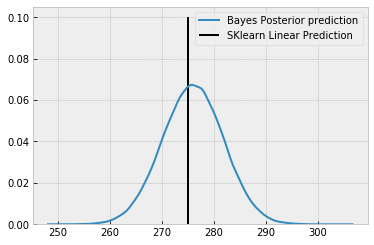

In [39]:
single_point_prediction = linear_trace['Intercept'] + linear_trace['slope']*30

plt.vlines(x=lin_reg.intercept_+lin_reg.coef_[0]*30, ymin=0, ymax=0.1,
          label='SKlearn Linear Prediction', )
sns.kdeplot(single_point_prediction, label='Bayes Posterior prediction')

**You have reached the end of this module.**

If you have any questions, please reach out to your peers using the discussion boards. If you and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to your instructor on the designated discussion board.

*When you are comfortable with the content, and have practiced to your satisfaction, you may proceed to any related assignments, and to the next module.*